In [3]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
import prince

In [2]:
import sys
#!{sys.executable} -m pip install prince

<h2>Task 1</h2>

In [2]:
iris = load_iris()

In [3]:
X = pd.DataFrame(data=iris.data, columns=iris.feature_names)
y = pd.DataFrame({'species': iris.target})

In [4]:
X.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [5]:
X.shape

(150, 4)

In [6]:
y.value_counts()

species
0          50
1          50
2          50
Name: count, dtype: int64

In [7]:
def scale_data(x):
    """
    Scales the features.
    """
    scaler = StandardScaler()
    scaler.fit(x)
    x = scaler.fit_transform(x)
    print(f'Mean of each feature after scaling: {np.round(np.mean(x, axis=0),3)}')
    print(f'SD of each feature after scaling: {np.std(x, axis=0)}')
    return x

In [8]:
X = scale_data(X)

Mean of each feature after scaling: [-0. -0. -0. -0.]
SD of each feature after scaling: [1. 1. 1. 1.]


In [9]:
np.unique(y, return_counts=True)

(array([0, 1, 2]), array([50, 50, 50]))

<h3>Kernel PCA</h3>

In [13]:
def kernel_PCA(X, kernel, num_components=None, gamma=None, coef0=None, alpha=None):
    """
    Args:
    X_train -- the training data
    kernel -- the kernel to be used
    num_components -- the number of components to preserve
    gamma -- kernel coefficient for 'rbf', 'poly', and 'sigmoid' kernels
    coef0 -- independent term in 'poly' and 'sigmoid' kernels
    alpha -- hyperparameter controlling the strength of ridge regression (when fit_inverse_transform=True)
    """
    kpca_model = KernelPCA(n_components=num_components, kernel=kernel)
    kpca_result = kpca_model.fit_transform(X)
    
    # Explained variance ratio
    explained_variance = np.var(kpca_result, axis=0)
    explained_variance_ratio = explained_variance / np.sum(explained_variance)
    return {
        'model': kpca_model,
        'result': kpca_result,
        'evr': explained_variance_ratio
    }

In [21]:
def plot_cumulative_var_explained(kpca):
    plt.plot(np.cumsum(kpca['evr']), color='black', zorder=2)
    plt.xticks(np.arange(0, len(kpca['evr'])))
    plt.grid(True, zorder=1, alpha=0.3)
    df = pd.DataFrame({
        'Explained variance ratio': kpca['evr'] * np.sum(kpca['evr']),
        'Cumulative variance ratio': np.cumsum(kpca['evr'])
    })
    pc_names = [f'PC{+i+1}' for i in range(len(kpca['evr']))]
    df.index = pc_names
    return df

,Explained variance ratio,Cumulative variance ratio
PC1,0.729624,0.729624
PC2,0.228508,0.958132
PC3,0.036689,0.994821
PC4,0.005179,1.000000


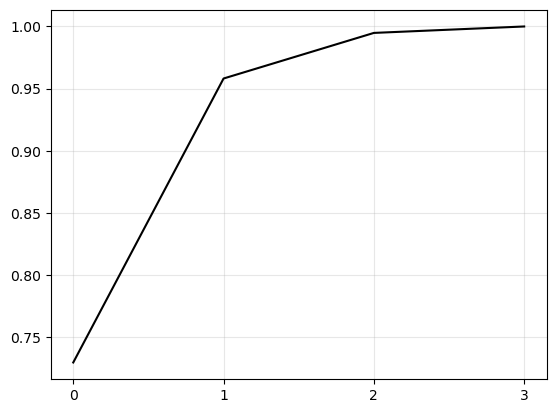

In [23]:
plot_cumulative_var_explained(kernel_PCA(X=X, kernel='linear'))

,Explained variance ratio,Cumulative variance ratio
PC1,4.001679e-01,0.400168
PC2,1.814266e-01,0.581595
PC3,8.736522e-02,0.668960
PC4,7.846225e-02,0.747422
PC5,5.300028e-02,0.800422
...,...,...
PC144,1.523087e-09,1.000000
PC145,7.763664e-10,1.000000
PC146,5.067109e-10,1.000000
PC147,4.442112e-10,1.000000


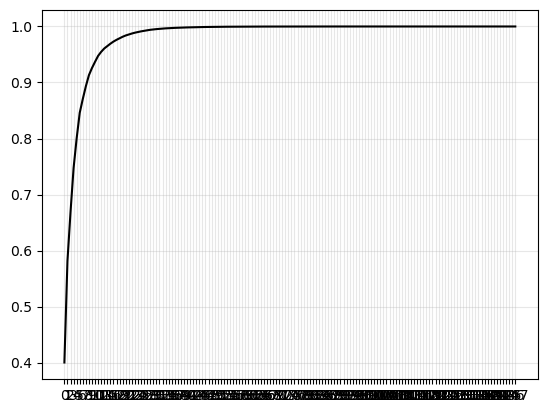

In [30]:
plot_cumulative_var_explained(kernel_PCA(X=X, kernel='rbf', num_components=None))

In [31]:
def pca(X):
    pca_model = PCA(n_components=None)
    pca_result = pca_model.fit_transform(X_train)
    return {
        'model': pca_model,
        'result': pca_result,
        'evr': pca_model.explained_variance_ratio_
    }

,Explained variance ratio,Cumulative variance ratio
PC1,0.729624,0.729624
PC2,0.228508,0.958132
PC3,0.036689,0.994821
PC4,0.005179,1.000000


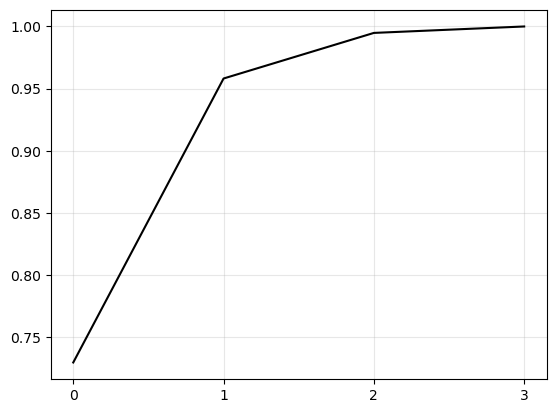

In [32]:
plot_cumulative_var_explained(pca(X))

- Notice that the when using kernel='linear' in kernel PCA, the result is the same as with normal PCA (which is a *linear* dimensionality reduction technique).

<h3>Hyperparameter tuning</h3>

In [56]:
def optimize_clf(X, y):
    """
    Notes:
    - The double underscore __ notation (e.g., kpca__kernel) tells GridSearchCV 
      to look inside the pipeline and optimize the specified hyperparams.
    """
    pipe = Pipeline([
        ('kpca', KernelPCA()),
        ('svc', SVC())
    ])
    
    base_svm = SVC()
    param_grid = {
        'kpca__kernel': ['linear', 'rbf', 'poly'],    # Different kernels to try in KernelPCA
        'kpca__gamma': [0.02,0.04,0.06,0.08,0.1],    # Kernel coefficient ('rbf', 'poly', 'sigmoid')
        'kpca__degree': [2, 3],                       # Only used for 'poly' kernel
        'kpca__coef0': [0.02,0.04,0.06,0.08,0.1],    # Independent term ('poly', 'sigmoid')
        'svc__C': [0.98,1.0,1.02],                    # SVC regularization parameter
        'svc__kernel': ['linear', 'rbf', 'poly'],     # Kernels for SVC
        'svc__gamma': ['scale'],                      # Gamma for SVC 'rbf' and 'poly'
        'svc__degree': [2, 3],                        # Only for SVC 'poly' kernel
    }
    
    ##### Grid search with CV #####
    grid = GridSearchCV(pipe, param_grid)
    grid.fit(X, y)
    
    ##### The best performing model, its parameters, and CV score #####
    best_model = grid.best_estimator_
    best_params = grid.best_params_
    best_model_cv_accuracy = grid.best_score_
    
    ##### Predictions #####
    y_pred_train = best_model.predict(X)
    
    ##### The performance of the model #####
    train_accuracy = accuracy_score(y_true=y, y_pred=y_pred_train)
    
    print(f'Training accuracy: {np.round(train_accuracy, 3)}')
    print(f"The best performing model's CV accuracy: {np.round(best_model_cv_accuracy, 3)}")
    
    return {
        'best_model': best_model,
        'best_params': best_params
    }

In [57]:
optimization_result = optimize_clf(X, y.values.ravel())

Training accuracy: 0.98
The best performing model's CV accuracy: 0.973


In [60]:
optimization_result['best_params']

{'kpca__coef0': 0.02,
 'kpca__degree': 2,
 'kpca__gamma': 0.08,
 'kpca__kernel': 'rbf',
 'svc__C': 1.02,
 'svc__degree': 2,
 'svc__gamma': 'scale',
 'svc__kernel': 'linear'}

In [23]:
optimization_result['best_model']

Pipeline(steps=[('kpca',
                 KernelPCA(coef0=0.02, degree=2, gamma=0.08, kernel='rbf')),
                ('svc', SVC(C=1.02, degree=2, kernel='linear'))])

In [58]:
def SVM_w_transform(X, y, kernel_kpca, kernel_svc, gamma_kpca, gamma_svc, coef0, degree, C, num_components):
    """
    n_components specifies the dimension of the space that the data is projected
    back into after the kernel trick.
    """
    ##### Kernel PCA #####
    kpca = KernelPCA(n_components=num_components, 
                     kernel=kernel_kpca, 
                     coef0=coef0, 
                     degree=degree,
                     gamma=gamma_kpca)
    X_transformed = kpca.fit_transform(X) 
    
    ##### SVM #####
    svm = SVC(C=C, gamma=gamma_svc, kernel=kernel_svc, degree=degree)
    svm.fit(X_transformed, y)
    
    y_train_preds = svm.predict(X_transformed)
    train_accuracy = accuracy_score(y_true=y, y_pred=y_train_preds)
    
    print(f'##### Number of components: {i} #####')
    print(f'Training accuracy: {np.round(train_accuracy, 3)}')
    print(f'Mean CV score: {np.round(np.mean(cross_val_score(svm, X_transformed, y, cv=5)), 3)}')
    print()

In [66]:
for i in range(1, 16):
    SVM_w_transform(X,
                    y.values.ravel(),
                    kernel_kpca='rbf',
                    kernel_svc='linear',
                    gamma_kpca=0.08,
                    gamma_svc='scale',
                    degree=3,
                    coef0=0.02,
                    C=1.02,
                    num_components=i)

##### Number of components: 1 #####
Training accuracy: 0.913
Mean CV score: 0.927

##### Number of components: 2 #####
Training accuracy: 0.873
Mean CV score: 0.873

##### Number of components: 3 #####
Training accuracy: 0.893
Mean CV score: 0.853

##### Number of components: 4 #####
Training accuracy: 0.893
Mean CV score: 0.86

##### Number of components: 5 #####
Training accuracy: 0.96
Mean CV score: 0.96

##### Number of components: 6 #####
Training accuracy: 0.967
Mean CV score: 0.96

##### Number of components: 7 #####
Training accuracy: 0.973
Mean CV score: 0.967

##### Number of components: 8 #####
Training accuracy: 0.973
Mean CV score: 0.967

##### Number of components: 9 #####
Training accuracy: 0.973
Mean CV score: 0.967

##### Number of components: 10 #####
Training accuracy: 0.98
Mean CV score: 0.967

##### Number of components: 11 #####
Training accuracy: 0.98
Mean CV score: 0.973

##### Number of components: 12 #####
Training accuracy: 0.98
Mean CV score: 0.973

##### Nu

In [82]:
def plot_kpca(X, y, kernel, degree=2):
    ##### Kernel PCA #####
    kpca = KernelPCA(n_components=2,
                     coef0=0.03,
                     gamma=0.04,
                     kernel=kernel,
                     degree=degree)
    X_transformed = kpca.fit_transform(X)
    
    ##### Plotting #####
    palette = sns.color_palette(palette='pastel6', n_colors=len(np.unique(y)))
    unique_labels = np.unique(y)
    label_names = iris.target_names
    plt.figure(figsize=(8,6), dpi=100)
    for label in unique_labels:
        mask = y == label
        plt.scatter(X_transformed[mask, 0], 
                    X_transformed[mask, 1], 
                    color=palette[label],
                    label=label_names[label])
    
    if kernel == 'poly':
        plt.title(f' polynomial kernel with degree {degree}')
    else:   
        plt.title(f'{kernel} kernel')
    plt.legend()

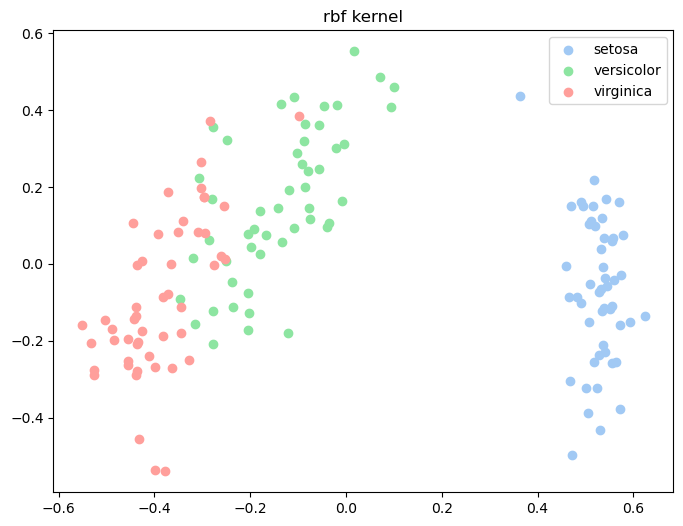

In [83]:
plot_kpca(X, y.values.ravel(), kernel='rbf')

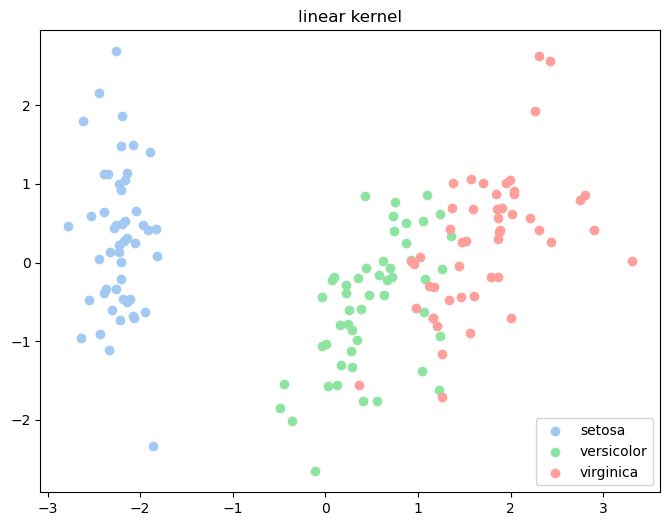

In [84]:
plot_kpca(X, y.values.ravel(), kernel='linear')

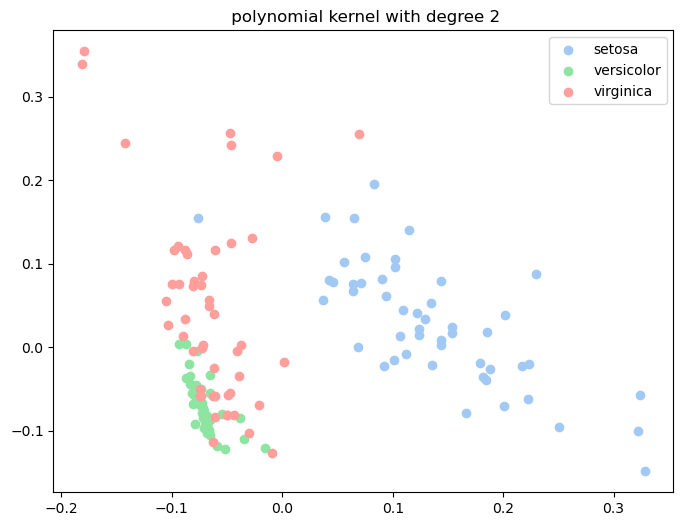

In [85]:
plot_kpca(X, y.values.ravel(), kernel='poly')

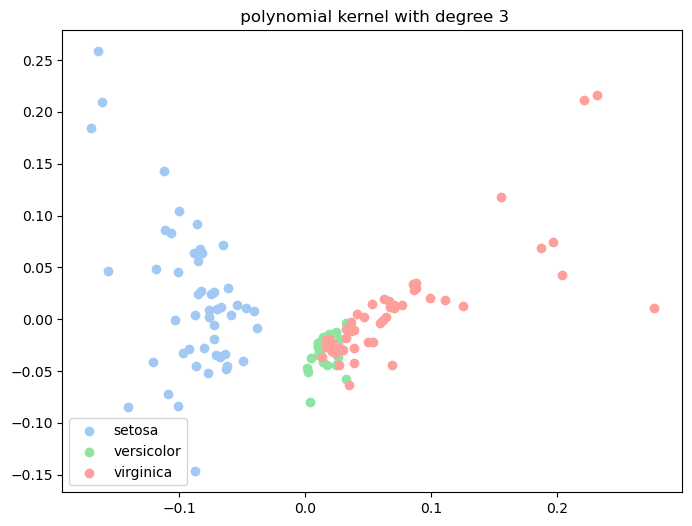

In [86]:
plot_kpca(X, y.values.ravel(), kernel='poly', degree=3)

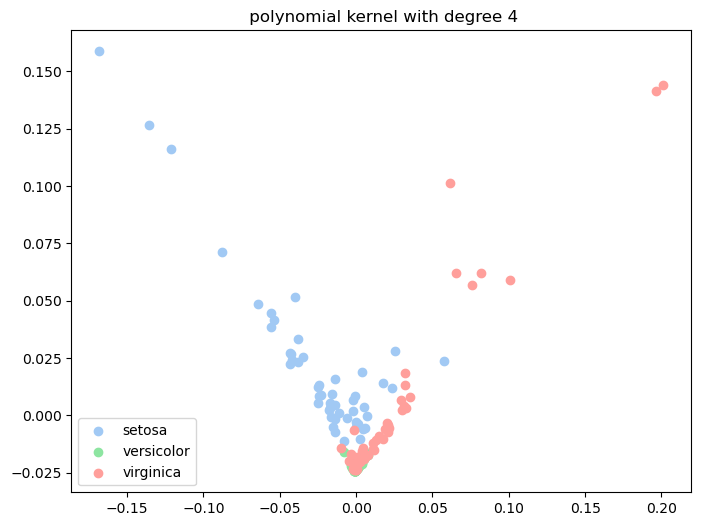

In [87]:
plot_kpca(X, y.values.ravel(), kernel='poly', degree=4)

<br>

<h3>Task 4</h3>

In [5]:
education = pd.read_csv('/Users/herrakaava/Documents/school/monimuuttujamenetelmat/week_6/koulutus.csv')

In [6]:
education.head()

,Alue,PA,TEA,KA
0,MK01 Uusimaa,367866,495507,574890
1,MK02 Varsinais-Suomi,104728,174648,134188
2,MK04 Satakunta,51483,83221,49354
3,MK05 Kanta-Häme,38745,64207,42417
4,MK06 Pirkanmaa,102643,192172,152614


In [7]:
education.shape

(18, 4)

In [8]:
education.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Alue    18 non-null     object
 1   PA      18 non-null     int64 
 2   TEA     18 non-null     int64 
 3   KA      18 non-null     int64 
dtypes: int64(3), object(1)
memory usage: 708.0+ bytes


In [9]:
education.isna().any().any()

np.False_

In [10]:
education['Alue'].values[:, np.newaxis]

array([['MK01 Uusimaa'],
       ['MK02 Varsinais-Suomi'],
       ['MK04 Satakunta'],
       ['MK05 Kanta-Häme'],
       ['MK06 Pirkanmaa'],
       ['MK07 Päijät-Häme'],
       ['MK08 Kymenlaakso'],
       ['MK09 Etelä-Karjala'],
       ['MK10 Etelä-Savo'],
       ['MK11 Pohjois-Savo'],
       ['MK12 Pohjois-Karjala'],
       ['MK13 Keski-Suomi'],
       ['MK14 Etelä-Pohjanmaa'],
       ['MK15 Pohjanmaa'],
       ['MK16 Keski-Pohjanmaa'],
       ['MK17 Pohjois-Pohjanmaa'],
       ['MK18 Kainuu'],
       ['MK19 Lappi']], dtype=object)

In [11]:
row_profiles = education.drop('Alue', axis=1) / np.sum(education.drop('Alue', axis=1).values, axis=1)[:, np.newaxis]
row_profiles.index = education.loc[:, 'Alue'].values

In [12]:
avg_profiles = education.drop('Alue', axis=1).sum(axis=0) / np.sum(education.drop('Alue', axis=1).values.ravel())

In [13]:
avg_profiles

PA     0.254032
TEA    0.415490
KA     0.330477
dtype: float64

In [14]:
print(row_profiles)

                              PA       TEA        KA
MK01 Uusimaa            0.255771  0.344518  0.399711
MK02 Varsinais-Suomi    0.253233  0.422300  0.324467
MK04 Satakunta          0.279711  0.452146  0.268144
MK05 Kanta-Häme         0.266529  0.441683  0.291788
MK06 Pirkanmaa          0.229406  0.429503  0.341091
MK07 Päijät-Häme        0.284192  0.437621  0.278187
MK08 Kymenlaakso        0.269679  0.461127  0.269195
MK09 Etelä-Karjala      0.264857  0.450277  0.284866
MK10 Etelä-Savo         0.272535  0.458991  0.268475
MK11 Pohjois-Savo       0.242760  0.462941  0.294299
MK12 Pohjois-Karjala    0.250244  0.475942  0.273814
MK13 Keski-Suomi        0.239317  0.448385  0.312298
MK14 Etelä-Pohjanmaa    0.270603  0.464223  0.265174
MK15 Pohjanmaa          0.262073  0.418792  0.319135
MK16 Keski-Pohjanmaa    0.274028  0.458890  0.267082
MK17 Pohjois-Pohjanmaa  0.236829  0.454051  0.309120
MK18 Kainuu             0.257848  0.482989  0.259163
MK19 Lappi              0.243653  0.475433  0.

In [15]:
def v1(data, labels):
    plt.figure(figsize=(8,6), dpi=100)
    plt.scatter(data[:,0], data[:,1], facecolors='none', edgecolors='black')
    plt.xlabel('Without post-primary education')
    plt.ylabel('Secondary or vocational education')
    for i, label in enumerate(labels):
        plt.text(x=data[i,0]+0.0004, y=data[i,1], s=label, fontsize=8)

In [16]:
labels = [s.split()[-1] for s in list(education.loc[:, 'Alue'])]

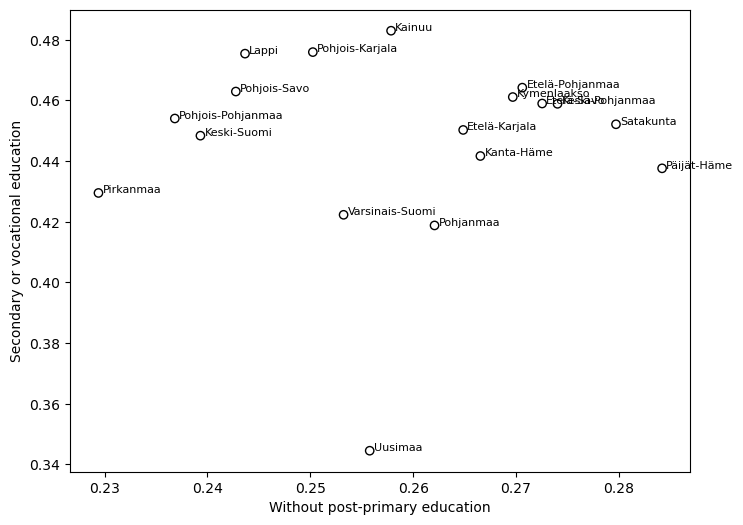

In [17]:
v1(row_profiles.values, labels)

In [19]:
# CA using the Prince library
ca_model = prince.CA(n_components=2)
ca_fit = ca_model.fit(education.drop('Alue', axis=1))

# The principal row coordinates
X = ca_fit.row_coordinates(education.drop('Alue', axis=1))

# The principal column coordinates
Y = ca_fit.column_coordinates(education.drop('Alue', axis=1))

In [31]:
# The total variance (inertia) explained each principal components in the CA
total_var = np.round(ca_fit.percentage_of_variance_, 2)

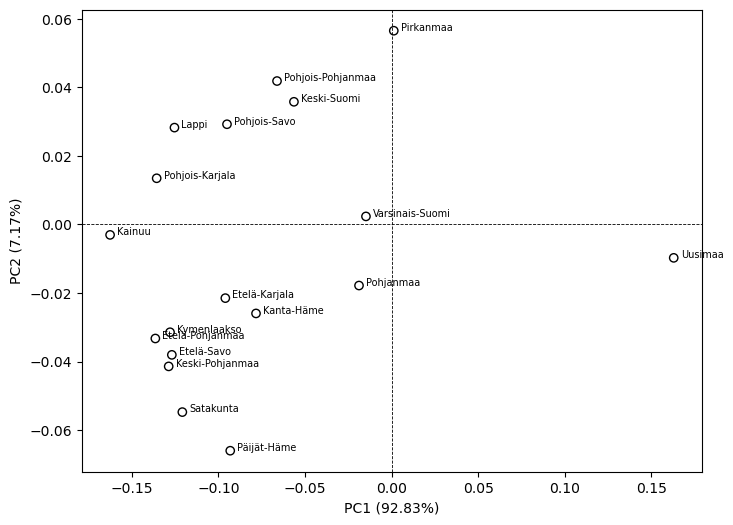

In [32]:
plt.figure(figsize=(8,6), dpi=100)
plt.scatter(X.values[:,0], X.values[:,1], facecolors='none', edgecolors='black', zorder=3)
for i, label in enumerate(labels):
    plt.text(x=X.iloc[i,0]+0.004, y=X.iloc[i,1], s=label, fontsize=7)
plt.axhline(y=0, linestyle='--', color='black', linewidth=0.6, zorder=1)
plt.axvline(x=0, linestyle='--', color='black', linewidth=0.6, zorder=2)
plt.xlabel(f'PC1 ({total_var[0]}%)')
plt.ylabel(f'PC2 ({total_var[1]}%)');

- Regions that are closer together have more similar educational profiles (i.e., the distribution of the people in terms of their educational profiles are more similar for these regions).

- Conversely, regions that are farther apart have more dissimilar educational profiles.

General guidelines for interpretation:
- The origin corresponds to the average row and column profiles.
- The (Euclidean) distance of a row point from the origin reflects the $\chi^2$ -distance of the row profile from the average row profile (cf. p. 117). Thus, a long distance indicates that there is at least one strong association present in the associated row with some column.
- If two row points are close to each other, then their row profiles should be similar.
- Analogous remarks apply to column points and their distances.

In [149]:
X

,0,1
0,0.162925,-0.009742
1,-0.014760,0.002358
2,-0.120778,-0.054766
3,-0.078237,-0.025965
4,0.001304,0.056560
5,-0.093122,-0.066042
6,-0.127870,-0.031455
7,-0.095951,-0.021498
8,-0.126832,-0.038058
9,-0.094993,0.029261


In [21]:
Y

,0,1
PA,-0.007027,-0.055393
TEA,-0.117680,0.020040
KA,0.153353,0.017384


In [37]:
ca.plot(education.drop('Alue', axis=1))

alt.LayerChart(...)

In [36]:
# Total intertia
ca_fit.total_inertia_.item()

0.014584584689795375

- The total inertia ($\phi^2$) of the contingency table aggregates (crudely) the total deviation from independence (no association) between rows and columns.
- A higher inertia indicates a stronger association between the row and column variables (conversely, a lower inertia indicates a weaker association).
- The total inertia is a measure of the strength of association between the rows and columns in the contingency table.
- In our example, the total inertia quantifies the association (variability) between the regions and the educational levels in the contingency table.

In [146]:
def f(A, data, ax):
    row_sums = np.sum(data.drop('Alue', axis=1).values, axis=ax)[:, np.newaxis].astype(float)
    return np.round(np.sum(A.values * row_sums), 7).item()

In [147]:
f(X, education, ax=1)

-0.0

In [148]:
f(Y, education, ax=0)

0.0